Loading data from /Users/sirsloththelazy/Projects/Financial-policy-optimization-with-RL/notebooks/../data/raw/accepted_2007_to_2018.csv...

Dataset Shape (Sample): (100000, 151)

First 5 rows:
         id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  68407277        NaN     3600.0       3600.0           3600.0   36 months   
1  68355089        NaN    24700.0      24700.0          24700.0   36 months   
2  68341763        NaN    20000.0      20000.0          20000.0   60 months   
3  66310712        NaN    35000.0      35000.0          35000.0   60 months   
4  68476807        NaN    10400.0      10400.0          10400.0   60 months   

   int_rate  installment grade sub_grade  ... hardship_payoff_balance_amount  \
0     13.99       123.03     C        C4  ...                            NaN   
1     11.99       820.28     C        C1  ...                            NaN   
2     10.78       432.66     B        B4  ...                            NaN   
3     14.85 

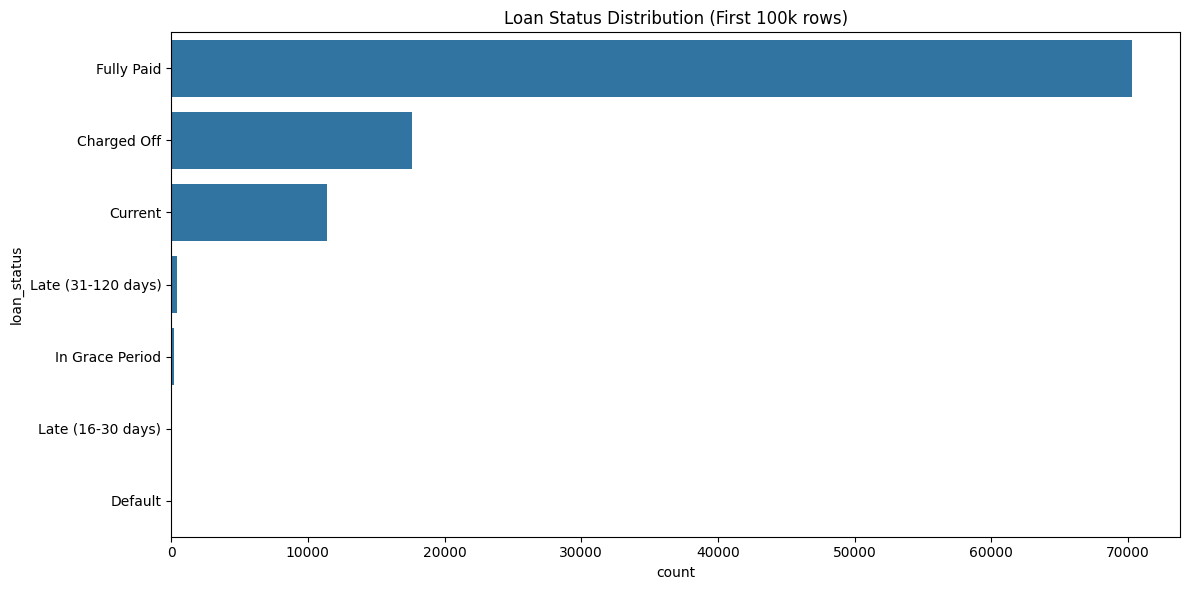

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# EDA script for analyzing a dataset of accepted loans from 2007 to 2018
try:
    ROOT = os.path.dirname(__file__)        
except NameError:
    ROOT = os.getcwd()                      

DATA_PATH = os.path.join(ROOT, "../data/raw/accepted_2007_to_2018.csv")


def run_eda():
    if not os.path.exists(DATA_PATH):
        print(f"Error: File not found at {DATA_PATH}")
        return

    print(f"Loading data from {DATA_PATH}...")
    df = pd.read_csv(DATA_PATH, low_memory=False, nrows=100000)

    print(f"\nDataset Shape (Sample): {df.shape}")
    print("\nFirst 5 rows:")
    print(df.head())

    print("\nColumn Info:")
    print(df.info())

    print("\nMissing Values (Top 20):")
    missing = df.isnull().sum().sort_values(ascending=False).head(20)
    print(missing)

    # --- Loan Status Plot ---
    if 'loan_status' in df.columns:
        print("\nLoan Status Distribution:")
        print(df['loan_status'].value_counts(normalize=True))

        plt.figure(figsize=(12, 6))
        sns.countplot(y='loan_status', data=df,
                      order=df['loan_status'].value_counts().index)
        plt.title('Loan Status Distribution (First 100k rows)')
        plt.tight_layout()

        # Save output inside ROOT (works in notebook too)
        output_img = os.path.join(ROOT, "loan_status_distribution.png")
        plt.savefig(output_img)

        print(f"\nSaved distribution plot to {output_img}")
    else:
        print("\n'loan_status' column not found!")


if __name__ == "__main__":
    run_eda()


Loading data...
Filtered Dataset Shape: (176082, 152)
Default Rate: 0.1993
Dropping 57 columns with >50% missing values.

calculating correlations...

Top 10 Positive Correlations:
recoveries                 0.503158
collection_recovery_fee    0.500374
int_rate                   0.308937
acc_open_past_24mths       0.135290
total_rec_late_fee         0.124541
dti                        0.114731
num_tl_op_past_12m         0.114124
total_rec_int              0.092147
inq_last_6mths             0.090932
num_rev_tl_bal_gt_0        0.076582
Name: target, dtype: float64

Top 10 Negative Correlations:
avg_cur_bal            -0.078136
bc_open_to_buy         -0.087050
fico_range_high        -0.136505
fico_range_low         -0.136506
total_pymnt            -0.307306
total_pymnt_inv        -0.307414
last_pymnt_amnt        -0.320462
total_rec_prncp        -0.433264
last_fico_range_low    -0.594829
last_fico_range_high   -0.686015
Name: target, dtype: float64


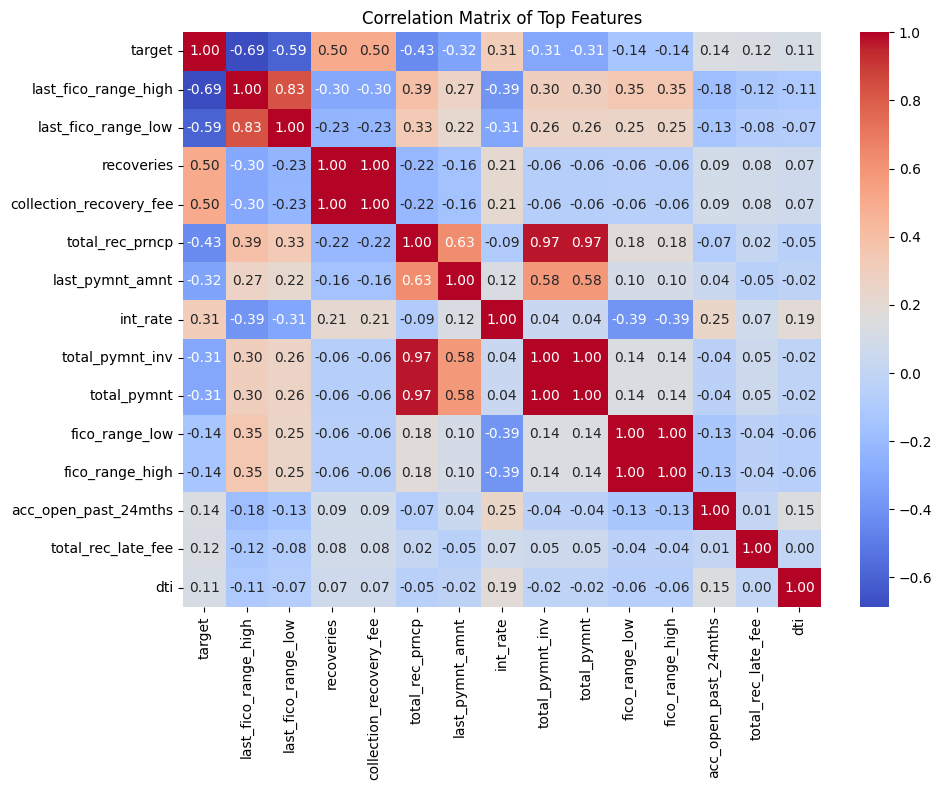

Saved /Users/sirsloththelazy/Projects/Financial-policy-optimization-with-RL/notebooks/notebooks/correlation_matrix.png


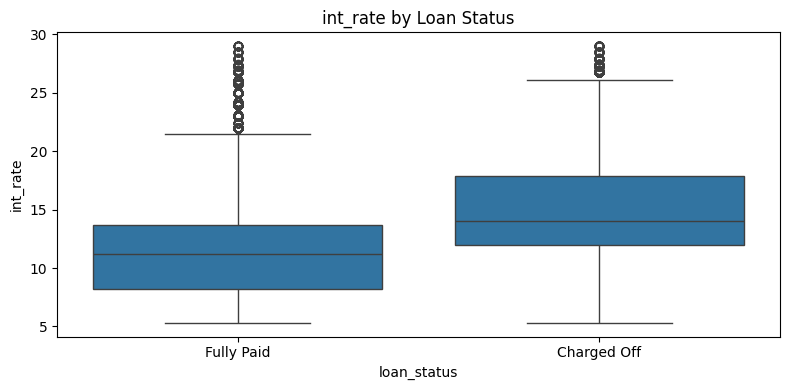

Saved /Users/sirsloththelazy/Projects/Financial-policy-optimization-with-RL/notebooks/notebooks/dist_int_rate.png


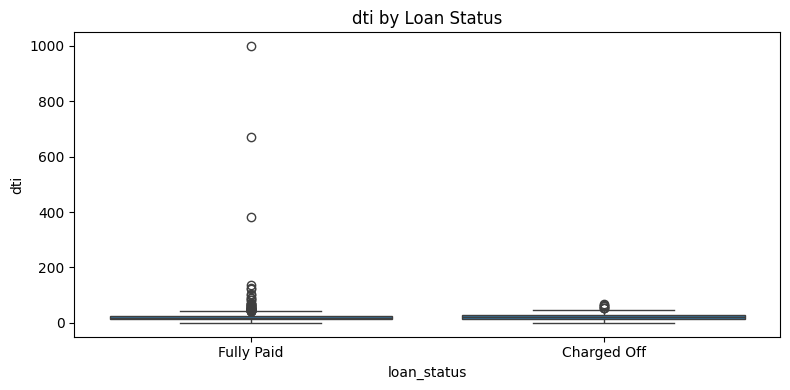

Saved /Users/sirsloththelazy/Projects/Financial-policy-optimization-with-RL/notebooks/notebooks/dist_dti.png


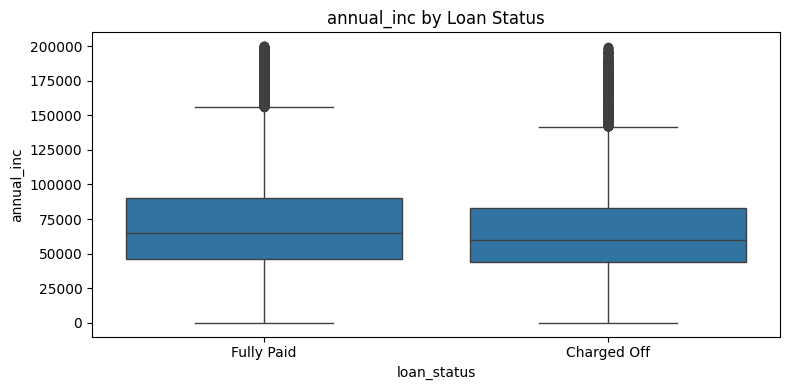

Saved /Users/sirsloththelazy/Projects/Financial-policy-optimization-with-RL/notebooks/notebooks/dist_annual_inc.png


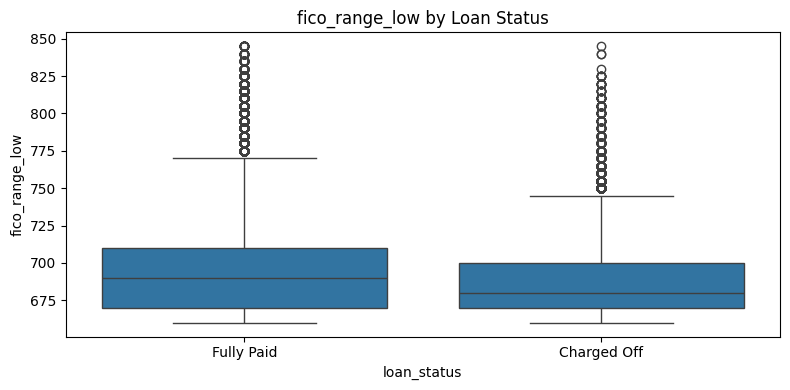

Saved /Users/sirsloththelazy/Projects/Financial-policy-optimization-with-RL/notebooks/notebooks/dist_fico_range_low.png


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os


%matplotlib inline


try:
    ROOT = os.path.dirname(__file__)
except NameError:
    ROOT = os.getcwd()

DATA_PATH = os.path.join(ROOT, "../data/raw/accepted_2007_to_2018.csv")
OUTPUT_DIR = os.path.join(ROOT, "notebooks")
os.makedirs(OUTPUT_DIR, exist_ok=True)


def analyze_features():
    print("Loading data...")
    df = pd.read_csv(DATA_PATH, low_memory=False, nrows=200000)

    df = df[df["loan_status"].isin(["Fully Paid", "Charged Off"])].copy()
    df["target"] = df["loan_status"].apply(lambda x: 1 if x == "Charged Off" else 0)

    print(f"Filtered Dataset Shape: {df.shape}")
    print(f"Default Rate: {df['target'].mean():.4f}")

    # Drop high missing columns
    missing_frac = df.isnull().mean()
    drop_cols = missing_frac[missing_frac > 0.5].index
    print(f"Dropping {len(drop_cols)} columns with >50% missing values.")
    df_clean = df.drop(columns=drop_cols)

    # Numeric columns
    numeric_df = df_clean.select_dtypes(include=[np.number]).copy()

    # Remove all-NaN numeric columns
    all_nan_cols = numeric_df.columns[numeric_df.isna().all()].tolist()
    numeric_df.drop(columns=all_nan_cols, inplace=True, errors="ignore")

    # Remove constant numeric columns
    const_cols = numeric_df.columns[numeric_df.nunique() <= 1].tolist()
    numeric_df.drop(columns=const_cols, inplace=True, errors="ignore")

    print("\ncalculating correlations...")
    correlations = numeric_df.corr()["target"].sort_values(ascending=False)

    print("\nTop 10 Positive Correlations:")
    print(correlations.drop("target").head(10))

    print("\nTop 10 Negative Correlations:")
    print(correlations.drop("target").tail(10))

    # Top correlated features
    top_corr_features = correlations.abs().sort_values(ascending=False).head(15).index.tolist()

    plt.figure(figsize=(10, 8))
    sns.heatmap(numeric_df[top_corr_features].corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Matrix of Top Features")
    plt.tight_layout()

    img_path = os.path.join(OUTPUT_DIR, "correlation_matrix.png")
    plt.savefig(img_path)
    plt.show()    # <----- show inline
    print(f"Saved {img_path}")

    # Key distributions
    key_features = ["int_rate", "dti", "annual_inc", "fico_range_low"]

    for feat in key_features:
        if feat in df_clean.columns:
            plt.figure(figsize=(8, 4))
            subset = df_clean
            if feat == "annual_inc":
                subset = df_clean[df_clean["annual_inc"] < 200000]

            sns.boxplot(x="loan_status", y=feat, data=subset)
            plt.title(f"{feat} by Loan Status")
            plt.tight_layout()

            outpath = os.path.join(OUTPUT_DIR, f"dist_{feat}.png")
            plt.savefig(outpath)
            plt.show()   # <----- show inline
            print(f"Saved {outpath}")


if __name__ == "__main__":
    analyze_features()


In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt


try:
    ROOT = os.path.dirname(__file__)
except NameError:
    ROOT = os.getcwd()

PROCESSED_DIR = os.path.join(os.path.dirname(ROOT), 'data/processed')

def inspect_processed_data():
    x_path = os.path.join(PROCESSED_DIR, 'X.npy')
    y_path = os.path.join(PROCESSED_DIR, 'y.npy')
    names_path = os.path.join(PROCESSED_DIR, 'feature_names.npy')
    
    if not os.path.exists(x_path):
        print(f"Processed data not found at: {x_path}")
        return

    print("Loading processed data...")
    X = np.load(x_path)
    y = np.load(y_path)

    try:
        feature_names = np.load(names_path)
    except:
        feature_names = [f"Feature {i}" for i in range(X.shape[1])]
    
    print(f"\nX shape: {X.shape}")
    print(f"y shape: {y.shape}")
    
    print(f"\nFeature names ({len(feature_names)}):")
    print(feature_names[:10])
    
    print("\nClass distribution:")
    unique, counts = np.unique(y, return_counts=True)
    print(dict(zip(unique, counts)))

    print("\nChecking for NaNs in X:")
    if np.isnan(X).any():
        print("WARNING: NaNs found in X!")
    else:
        print("No NaNs found in X. Clean.")

    print("\nFeature Statistics (First 5 features):")
    for i in range(min(5, X.shape[1])):
        print(f"{feature_names[i]}: Mean={X[:, i].mean():.2f}, Std={X[:, i].std():.2f}")


if __name__ == "__main__":
    inspect_processed_data()


Loading processed data...

X shape: (44005, 129)
y shape: (44005,)

Feature names (129):
['Feature 0', 'Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5', 'Feature 6', 'Feature 7', 'Feature 8', 'Feature 9']

Class distribution:
{np.int64(0): np.int64(34978), np.int64(1): np.int64(9027)}

Checking for NaNs in X:
No NaNs found in X. Clean.

Feature Statistics (First 5 features):
Feature 0: Mean=0.00, Std=1.00
Feature 1: Mean=0.00, Std=1.00
Feature 2: Mean=0.00, Std=1.00
Feature 3: Mean=-0.00, Std=1.00
Feature 4: Mean=0.00, Std=1.00


Loading data and model...


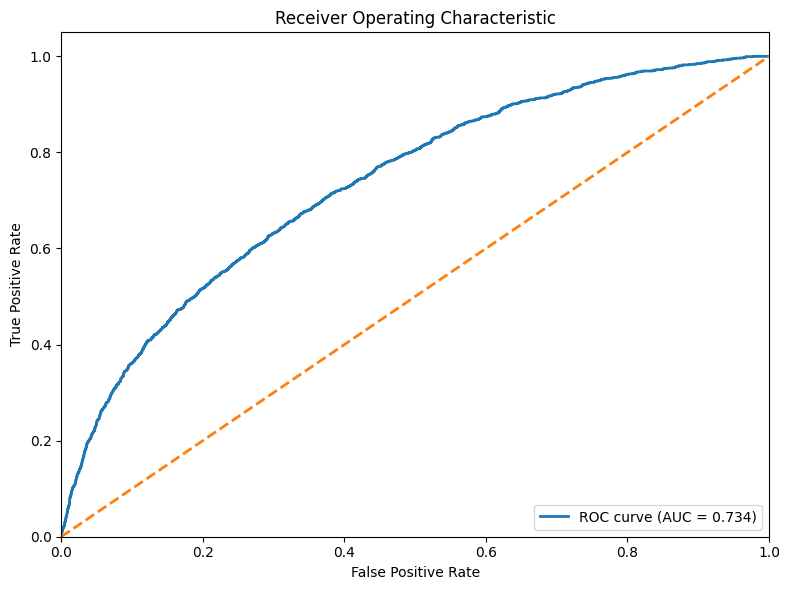

Saved ROC plot to /Users/sirsloththelazy/Projects/Financial-policy-optimization-with-RL/evaluation_outputs/roc_curve.png


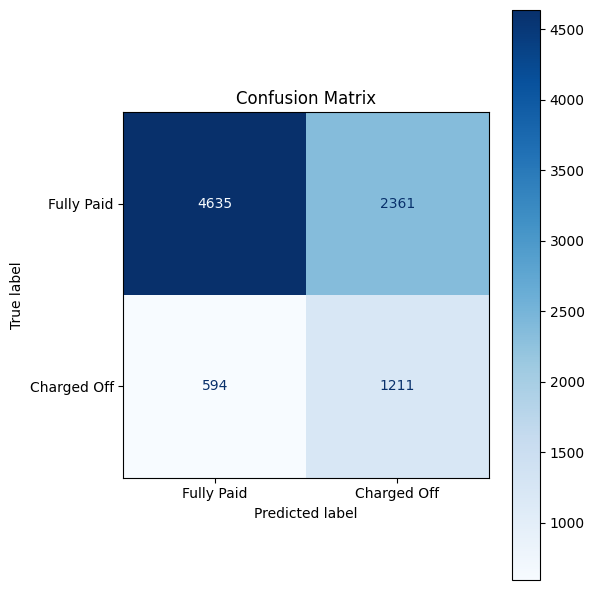

Saved confusion matrix to /Users/sirsloththelazy/Projects/Financial-policy-optimization-with-RL/evaluation_outputs/confusion_matrix.png

Classification report (on test set):
              precision    recall  f1-score   support

  Fully Paid       0.89      0.66      0.76      6996
 Charged Off       0.34      0.67      0.45      1805

    accuracy                           0.66      8801
   macro avg       0.61      0.67      0.60      8801
weighted avg       0.77      0.66      0.70      8801



In [ ]:

%matplotlib inline

import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay


try:
    BASE_DIR = os.path.dirname(os.path.dirname(__file__))
except NameError:
    BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))

DATA_DIR = os.path.join(BASE_DIR, 'data', 'processed')
MODEL_PATH = os.path.join(BASE_DIR, 'models', 'best_model.pkl')
OUTPUT_DIR = os.path.join(BASE_DIR, 'evaluation_outputs')
os.makedirs(OUTPUT_DIR, exist_ok=True)

def evaluate_model():
    if not os.path.exists(MODEL_PATH):
        print(f"Model not found at: {MODEL_PATH}")
        return

    print("Loading data and model...")
    X_path = os.path.join(DATA_DIR, 'X.npy')
    y_path = os.path.join(DATA_DIR, 'y.npy')

    if not os.path.exists(X_path) or not os.path.exists(y_path):
        print(f"Processed arrays not found in {DATA_DIR}")
        return

    X = np.load(X_path)
    y = np.load(y_path)
    model = joblib.load(MODEL_PATH)

    # Recreate a deterministic test split (if you saved indices earlier, prefer loading them)
    from sklearn.model_selection import train_test_split
    _, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # Get predicted probabilities or scores (robust fallback)
    y_prob = None
    if hasattr(model, "predict_proba"):
        try:
            y_prob = model.predict_proba(X_test)[:, 1]
        except Exception as e:
            print("predict_proba failed:", e)
            y_prob = None

    if y_prob is None and hasattr(model, "decision_function"):
        try:
            # decision_function may return shape (n_samples,) or (n_samples, n_classes)
            scores = model.decision_function(X_test)
            if scores.ndim == 1:
                # convert to probability-like via min-max for ROC ranking (not a true probability)
                y_prob = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)
            else:
                # take positive class column if multiclass-like output
                y_prob = scores[:, 1]
        except Exception as e:
            print("decision_function failed:", e)
            y_prob = None

    # final fallback: use predicted labels (ROC will be degenerate but still computable)
    y_pred = model.predict(X_test)
    if y_prob is None:
        print("Warning: model does not provide probabilities/scores; using predicted labels to compute ROC (AUC may be limited).")
        # make a 0/1 score from predictions to allow ROC curve (will create step-like ROC)
        y_prob = y_pred

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    roc_path = os.path.join(OUTPUT_DIR, 'roc_curve.png')
    plt.tight_layout()
    plt.savefig(roc_path)
    plt.show()
    print(f"Saved ROC plot to {roc_path}")

    # Confusion Matrix (use predicted labels)
    cm = confusion_matrix(y_test, y_pred)
    # Attempt to infer class order labels
    unique_labels = np.unique(y_test)
    if len(unique_labels) == 2:
        # map label values to names if they follow your earlier convention (0=Fully Paid,1=Charged Off)
        label_names = ['Fully Paid', 'Charged Off'] if set(unique_labels) == {0,1} else [str(l) for l in unique_labels]
    else:
        label_names = [str(l) for l in unique_labels]

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
    plt.title('Confusion Matrix')
    cm_path = os.path.join(OUTPUT_DIR, 'confusion_matrix.png')
    plt.tight_layout()
    plt.savefig(cm_path)
    plt.show()
    print(f"Saved confusion matrix to {cm_path}")

    # Optional: print classification counts and basic metrics
    from sklearn.metrics import classification_report
    print("\nClassification report (on test set):")
    print(classification_report(y_test, y_pred, target_names=label_names))

if __name__ == "__main__":
    evaluate_model()


Loading test data...


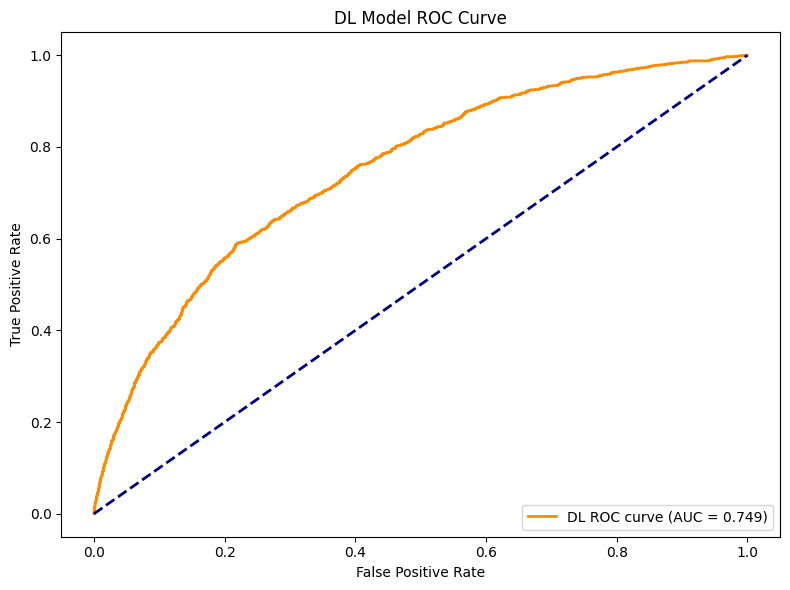

Saved roc_curve_dl.png


<Figure size 800x600 with 0 Axes>

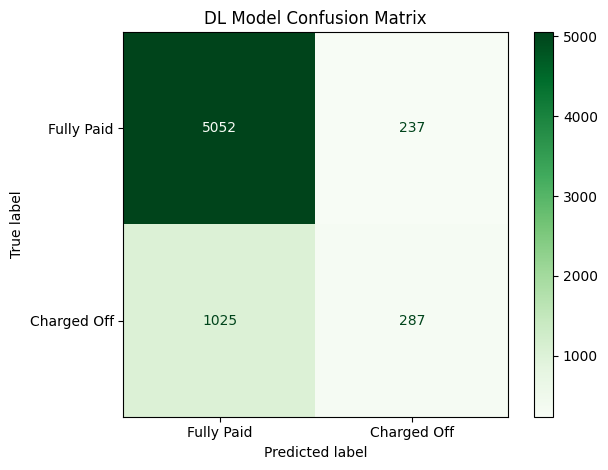

Saved confusion_matrix_dl.png

--- Evaluation Metrics ---
ROC AUC        : 0.7491
Average Precision (AP) : 0.4364
Accuracy       : 0.8088
Precision      : 0.5477
Recall         : 0.2188
F1 Score       : 0.3126

Classification Report:
              precision    recall  f1-score   support

  Fully Paid       0.83      0.96      0.89      5289
 Charged Off       0.55      0.22      0.31      1312

    accuracy                           0.81      6601
   macro avg       0.69      0.59      0.60      6601
weighted avg       0.77      0.81      0.77      6601



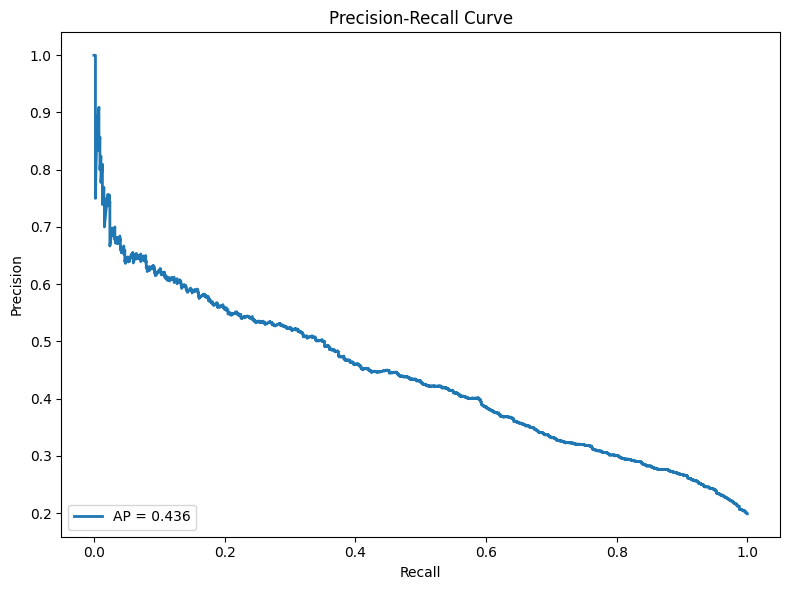

Saved pr_curve_dl.png


In [10]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, average_precision_score, precision_recall_curve
)
import sys

try:
    _HERE = os.path.dirname(__file__)
except NameError:
    _HERE = os.getcwd()

sys.path.append(os.path.join(os.path.dirname(_HERE), 'src'))

from dataset import LoanDataset
from models import LoanClassifier

BATCH_SIZE = 64
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
HIDDEN_DIM = 128
DROPOUT = 0.3

def evaluate_dl_model():
    try:
        BASE_DIR = os.path.dirname(os.path.dirname(__file__))
    except NameError:
        BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))

    DATA_DIR = os.path.join(BASE_DIR, 'data/processed')
    MODEL_PATH = os.path.join(BASE_DIR, 'models/best_dl_model.pth')
    
    if not os.path.exists(MODEL_PATH):
        print("Model not found.")
        return

    print("Loading test data...")
    test_ds = LoanDataset(DATA_DIR, mode='test')
    test_loader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE)
    
    input_dim = test_ds[0][0].shape[0]
    model = LoanClassifier(input_dim, hidden_dim=HIDDEN_DIM, dropout_rate=DROPOUT).to(DEVICE)
    model.load_state_dict(torch.load(MODEL_PATH))
    model.eval()
    
    targets = []
    preds = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(DEVICE)
            y_pred = model(X_batch)
            # collect targets and raw outputs
            targets.extend(y_batch.numpy())
            preds.extend(y_pred.cpu().numpy())
            
    targets = np.array(targets)
    preds = np.array(preds)
    
    # Flatten preds if shape is (N,1)
    preds = preds.ravel()
    
    # If outputs look like logits or outside [0,1], convert with sigmoid
    if preds.min() < 0 or preds.max() > 1:
        preds = 1 / (1 + np.exp(-preds))  # sigmoid
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(targets, preds)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'DL ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('DL Model ROC Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig('roc_curve_dl.png')
    plt.show()
    print("Saved roc_curve_dl.png")
    
    # Binary predictions at 0.5 threshold
    binary_preds = (preds > 0.5).astype(int)
    
    # Confusion Matrix
    cm = confusion_matrix(targets, binary_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fully Paid', 'Charged Off'])
    plt.figure(figsize=(8, 6))
    disp.plot(cmap=plt.cm.Greens)
    plt.title('DL Model Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix_dl.png')
    plt.show()
    print("Saved confusion_matrix_dl.png")
    
    # Basic metrics
    acc = accuracy_score(targets, binary_preds)
    prec = precision_score(targets, binary_preds, zero_division=0)
    rec = recall_score(targets, binary_preds, zero_division=0)
    f1 = f1_score(targets, binary_preds, zero_division=0)
    ap = average_precision_score(targets, preds)  # average precision (area under PR)
    
    print("\n--- Evaluation Metrics ---")
    print(f"ROC AUC        : {roc_auc:.4f}")
    print(f"Average Precision (AP) : {ap:.4f}")
    print(f"Accuracy       : {acc:.4f}")
    print(f"Precision      : {prec:.4f}")
    print(f"Recall         : {rec:.4f}")
    print(f"F1 Score       : {f1:.4f}")
    
    print("\nClassification Report:")
    # Map labels if 0/1 are used
    try:
        print(classification_report(targets, binary_preds, target_names=['Fully Paid', 'Charged Off']))
    except:
        print(classification_report(targets, binary_preds))
    
    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(targets, preds)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, lw=2, label=f'AP = {ap:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.savefig('pr_curve_dl.png')
    plt.show()
    print("Saved pr_curve_dl.png")

if __name__ == "__main__":
    evaluate_dl_model()
